In [2]:
%matplotlib inline
# Imports
import pathlib
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

plt.rcParams["figure.figsize"] = (40, 20)

# Paths

In [3]:
data_dir = pathlib.Path("/mnt/share/raheppt1/data/brain/raw/OASIS-3/")

In [4]:
train_ix_fname = data_dir.joinpath("train.dat")
test_ix_fname = data_dir.joinpath("test.dat")
full_ix_fname = data_dir.joinpath("full.dat")
full_ages_fname = data_dir.joinpath("full_ages.csv")

oasis_dir = data_dir.joinpath("OASIS-3_NDARRAY_PTN_PTNF_Robex_Paired_DL")
oasis_fnames = {int(fname.stem.split("_")[-1]): fname for fname in oasis_dir.glob("*.h5")}
print(f"Resolutions: {sorted(oasis_fnames.keys())}")

Resolutions: [8, 16, 32, 64, 128, 256]


# MRI Scan Identifiers

In [5]:
for resolution in sorted(oasis_fnames.keys()):
    with h5py.File(oasis_fnames[resolution], "r") as f:
        # Extract members
        original_members = sorted(f["original"])
        convex_hull_members = sorted(f["convex_hull"])
        brain_mask_members = sorted(f["brain_mask"])

        print(f"Resolution {resolution}:")
        print(f"\t#original = {len(original_members)}, {original_members[:2]}..")
        print(f"\t#convex_hull = {len(convex_hull_members)}, {convex_hull_members[:2]}..")
        print(f"\t#brain_mask = {len(brain_mask_members)}, {brain_mask_members[:2]}..")


Resolution 8:
	#original = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#convex_hull = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#brain_mask = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
Resolution 16:
	#original = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#convex_hull = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#brain_mask = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
Resolution 32:
	#original = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#convex_hull = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#brain_mask = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
Resolution 64:
	#original = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#convex_hull = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
	#brain_mask = 2287, ['OAS30001_MR_d0129_anat2', 'OAS30001_MR_d0129_anat3']..
Resolutio

In [6]:
# I already executed this and the resulting files should be contained in the folder

"""
from sklearn.model_selection import train_test_split
train_ix, test_ix = train_test_split(original_members, train_size=.8)

train_ix_fname.write_text("\n".join(train_ix))
test_ix_fname.write_text("\n".join(test_ix))
full_ix_fname.write_text("\n".join(original_members))
"""

'\nfrom sklearn.model_selection import train_test_split\ntrain_ix, test_ix = train_test_split(original_members, train_size=.8)\n\ntrain_ix_fname.write_text("\n".join(train_ix))\ntest_ix_fname.write_text("\n".join(test_ix))\nfull_ix_fname.write_text("\n".join(original_members))\n'

# Load NumPy arrays from HDF5

In [7]:
example_ix = "OAS30001_MR_d0129_anat3"
for resolution in sorted(oasis_fnames.keys()):
    with h5py.File(oasis_fnames[resolution], "r") as f:

        # Extract data
        original = f["original"][example_ix][()]
        convex_hull = f["convex_hull"][example_ix][()]
        brain_mask = f["brain_mask"][example_ix][()]
        
        print(f"Resolution: original = {original.shape}\tconvex_hull = {convex_hull.shape}\tbrain_mask = {brain_mask.shape}")


Resolution: original = (8, 8, 8)	convex_hull = (8, 8, 8)	brain_mask = (8, 8, 8)
Resolution: original = (16, 16, 16)	convex_hull = (16, 16, 16)	brain_mask = (16, 16, 16)
Resolution: original = (32, 32, 32)	convex_hull = (32, 32, 32)	brain_mask = (32, 32, 32)
Resolution: original = (64, 64, 64)	convex_hull = (64, 64, 64)	brain_mask = (64, 64, 64)
Resolution: original = (128, 128, 128)	convex_hull = (128, 128, 128)	brain_mask = (128, 128, 128)
Resolution: original = (256, 256, 256)	convex_hull = (256, 256, 256)	brain_mask = (256, 256, 256)


# Visualize NumPy arrays

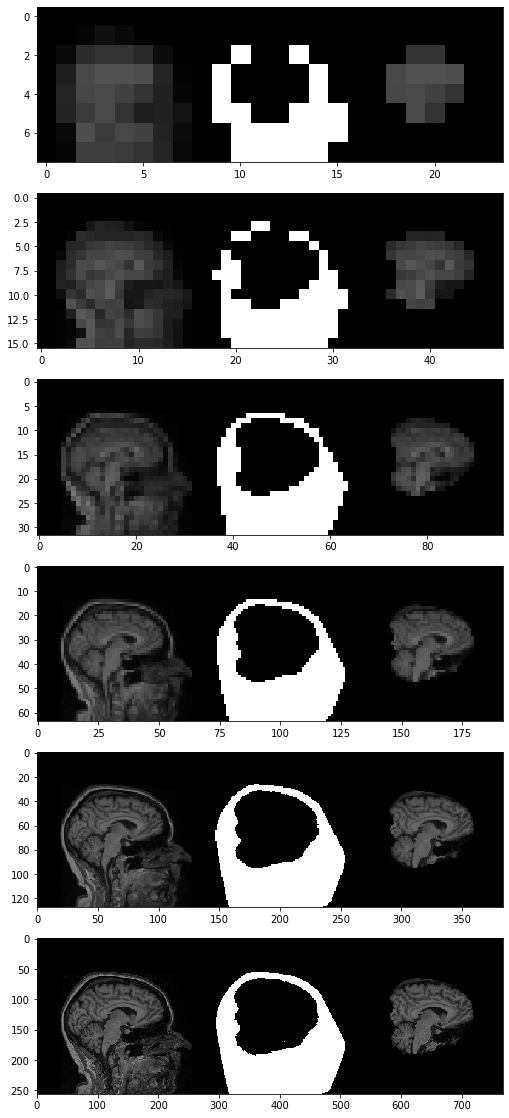

In [19]:
example_ix = "OAS30001_MR_d0129_anat3"
fig, ax = plt.subplots(nrows=len(oasis_fnames), ncols=1)
for i, resolution in enumerate(sorted(oasis_fnames.keys())):
    with h5py.File(oasis_fnames[resolution], "r") as f:

            # Extract data
            original = f["original"][example_ix][()]
            convex_hull = f["convex_hull"][example_ix][()]
            brain_mask = f["brain_mask"][example_ix][()]

            ax[i].imshow(np.flip(np.concatenate([original[:,resolution//2,:],
                                       (convex_hull*(1-brain_mask))[:,resolution//2,:],
                                       (original*brain_mask)[:,resolution//2,:]], axis=1), axis=0), cmap=plt.cm.gray)

# Neural Network Input Representation

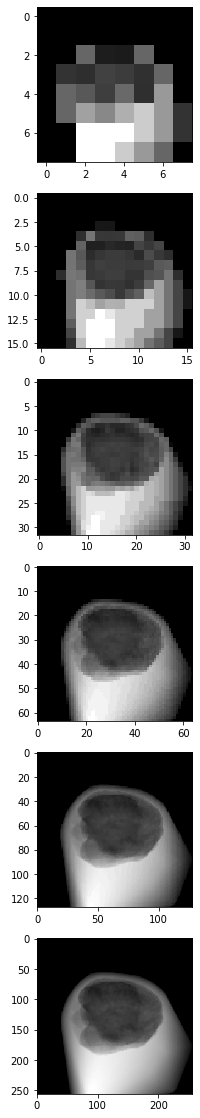

In [7]:
example_ix = "OAS30001_MR_d0129_anat3"
fig, ax = plt.subplots(nrows=len(oasis_fnames), ncols=1)
for i, resolution in enumerate(sorted(oasis_fnames.keys())):
    with h5py.File(oasis_fnames[resolution], "r") as f:

        # Extract data
        original = f["original"][example_ix][()]
        convex_hull = f["convex_hull"][example_ix][()]
        brain_mask = f["brain_mask"][example_ix][()]
        
        # Insert brain into convex hull
        img = np.where(brain_mask, original, convex_hull)
        
        ax[i].imshow(np.flip(img.mean(axis=1) ,axis=0), cmap=plt.cm.gray)
        

8
16
32
64
128
256


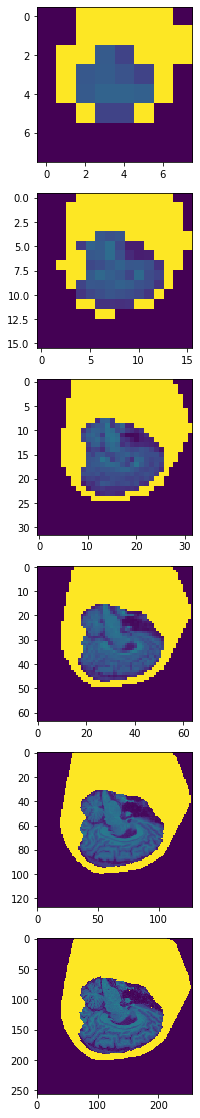

In [9]:
example_ix = "OAS30001_MR_d0129_anat3"
fig, ax = plt.subplots(nrows=len(oasis_fnames), ncols=1)
for i, resolution in enumerate(sorted(oasis_fnames.keys())):
    with h5py.File(oasis_fnames[resolution], "r") as f:

        # Extract data
        original = f["original"][example_ix][()]
        convex_hull = f["convex_hull"][example_ix][()]
        brain_mask = f["brain_mask"][example_ix][()]
        
        # Insert brain into convex hull
        img = np.where(brain_mask, original, convex_hull)
        print(resolution)

        ax[i].imshow(img[:,resolution//2,:])

# Exemplary PyTorch Data Pipeline

In [9]:
from torch.utils.data import Dataset as AbstractDataset
from torch.utils.data import DataLoader

# Age data
age_data = dict([line.split(",") for line in full_ages_fname.read_text().split("\n")][1:-1])

class Dataset(AbstractDataset):
    def __init__(self,
                 fname: pathlib.Path,
                 ix_fname: pathlib.Path):
        super().__init__()

        # Copy over
        self.fname = fname
        self.ix_fname = ix_fname

        # Read indices
        self.ix = sorted(set(self.ix_fname.read_text().strip().split("\n")))

    def __len__(self):
        return len(self.ix)

    def __getitem__(self, i):

        with h5py.File(self.fname, "r") as fhandle:
            example_ix = self.ix[i]

            # Extract data
            original = fhandle["original"][example_ix][()]
            convex_hull = fhandle["convex_hull"][example_ix][()]
            brain_mask = fhandle["brain_mask"][example_ix][()]
            age = float(age_data[example_ix])

            # Insert brain from original
            x = np.where(brain_mask, original, convex_hull)

            data = {
                "anonymized": x[np.newaxis, ...],
                "original": original[np.newaxis, ...],
                "brain_mask": brain_mask[np.newaxis, ...].astype(np.float32),
                "age": age
            }

            return {k: torch.tensor(arr) for k, arr in data.items()}


In [10]:
dataset = Dataset(fname=oasis_fnames[64], ix_fname=train_ix_fname)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [11]:
i, n = 0, 10
for batch in data_loader:
    if i == n:
        break
    
    print({k: list(v.shape) for k, v in batch.items()})
    break
    i += 1

{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 64], 'age': [8]}
{'anonymized': [8, 1, 64, 64, 64], 'original': [8, 1, 64, 64, 64], 'brain_mask': [8, 1, 64, 64, 